In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
from tqdm import tqdm
import torch

# If running in Google Colab, uncomment these lines to mount your Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

## Prepare Train Data:

We will first read file names:

In [15]:
# update the directories as needed
images_directory = os.path.join("./drive/My Drive/Colab Notebooks/images")
labels_directory = os.path.join("./drive/My Drive/Colab Notebooks/labels")
train_images = os.listdir(images_directory + "/train")
train_images.sort()

Next we make a copy of the files into mask and no_mask folders:

In [ ]:
import shutil

for train_image in tqdm(train_images):
  train_label = train_image.split(".")[0] + ".txt"
  if train_image != "subimages":
    f = open(labels_directory + "/train/" + train_label, "r+")
    f_read = (f.read().replace("\n", "")).split(" ")
    if len(f_read) > 5:
      continue    # For now, we skip the images with more than one mask
    classname = int(f_read[0])
    source = images_directory + "/train/" + train_image
    if classname == 0:
      distination = images_directory + "/train/subimages/mask/" + train_image
      if not os.path.exists(distination):
        shutil.copyfile(source, distination)
    elif classname == 1:
      distination = images_directory + "/train/subimages/no_mask/" + train_image
      if not os.path.exists(distination):
        shutil.copyfile(source, distination)
  else:
    pass

## Prepare Validation Data:

In [17]:
images_directory = os.path.join("./drive/My Drive/Colab Notebooks/images")
labels_directory = os.path.join("./drive/My Drive/Colab Notebooks/labels")
valid_images = os.listdir(images_directory + "/valid")
valid_images.sort()

In [ ]:
import shutil

for valid_image in tqdm(valid_images):
  valid_label = valid_image.split(".")[0] + ".txt"
  if valid_image != "subimages":
    f = open(labels_directory + "/valid/" + valid_label, "r+")
    f_read = (f.read().replace("\n", "")).split(" ")
    if len(f_read) > 5:
      continue    # For now, we skip the images with more than one mask
    classname = int(f_read[0])
    source = images_directory + "/valid/" + valid_image
    if classname == 0:
      distination = images_directory + "/valid/subimages/mask/" + valid_image
      if not os.path.exists(distination):
        shutil.copyfile(source, distination)
    elif classname == 1:
      distination = images_directory + "/valid/subimages/no_mask/" + valid_image
      if not os.path.exists(distination):
        shutil.copyfile(source, distination)
  else:
    pass

Prepare Test Data:

In [20]:
images_directory = os.path.join("./drive/My Drive/Colab Notebooks/images")
test_images = os.listdir(images_directory + "/test")
test_images.sort()

## Building Data Flow:

In [21]:
from torchvision import datasets, transforms, models
from torch import nn

In [22]:
train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor()])
valid_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor()])
train_data = datasets.ImageFolder(images_directory + "/train/subimages",
                                  transform=train_transforms)
valid_data = datasets.ImageFolder(images_directory + "/valid/subimages",
                                  transform=valid_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)

In [23]:

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor()])
test_data = datasets.ImageFolder(images_directory + "/test/subimages",
                                  transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=10)

## Building Transfer Learning Model:

In [ ]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss() #negative log likelihood

# Only train the classifier parameters, feature parameters are frozen
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

## Training the Model:

In [25]:
epochs = 2
steps = 0
running_loss = 0
print_every = 5
for epoch in tqdm(range(epochs)):
    for images, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for images, labels in validloader:
                    images, labels = images.to(device), labels.to(device)
                    logps = model.forward(images)
                    batch_loss = criterion(logps, labels)
                    
                    valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2.. Train loss: 0.662.. Validation loss: 0.404.. Validation accuracy: 0.785
Epoch 1/2.. Train loss: 0.580.. Validation loss: 0.390.. Validation accuracy: 0.771


 50%|█████     | 1/2 [04:02<04:02, 242.23s/it]

Epoch 2/2.. Train loss: 0.267.. Validation loss: 0.155.. Validation accuracy: 0.938
Epoch 2/2.. Train loss: 0.199.. Validation loss: 0.308.. Validation accuracy: 0.868


100%|██████████| 2/2 [08:03<00:00, 241.91s/it]


## Inference and Plotting:

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()
    plt.tight_layout()
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 3), ncols=2)
    ax1.imshow(img.permute(1, 2, 0))
    ax1.axis('off')
    ax2.barh(np.arange(2), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    ax2.set_yticklabels(["face_mask", "face_no_mask"])
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    return fig

In [27]:
%matplotlib inline
#images, labels = next(iter(trainloader))
for index, (images, labels) in enumerate(trainloader):
  if index == 2:
    break
# img = images[0].view(1, 2500)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model.forward(images)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)

In [ ]:
print("Example Training Image")
fig = view_classify(images[2], ps[2])
fig.show()

Example Test Image

In [29]:
%matplotlib inline
#images, labels = next(iter(trainloader))
for index, (images, labels) in enumerate(testloader):
  if index == 2:
    break
# img = images[0].view(1, 2500)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model.forward(images)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)

Example Test Image


<Figure size 432x288 with 0 Axes>

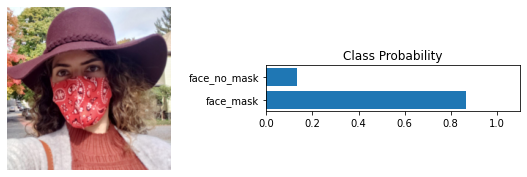

In [30]:
print("Example Test Image")
fig = view_classify(images[0], ps[0])
fig.show()

## Plotting the Confusion Matrix:

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

def plot_confusion_matrix(true_values, prediction_values):
  fig, ax = plt.subplots()
  cm = confusion_matrix(true_values, prediction_values)
  tn, fp, fn, tp = cm.ravel()
  print("TN:",tn, " FP:", fp, " FN:", fn, " TP:", tp)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mask", "No Mask"])
  disp.plot(cmap='GnBu', ax=ax)
  ax.set_title("densenet121")
  plt.show()

Let us first plot the confusion matrix on the train dataset:

In [32]:
y_train = []
pred_train = []
model.eval()
with torch.no_grad():
  for images, labels in trainloader:
    images, labels = images.to(device), labels.to(device)
    logps = model.forward(images)
    ps = torch.exp(logps)
    for i, p in enumerate(ps.numpy()):
      y_train.append(labels[i])
      pred_train.append(p.argmax())
print("len(y_train) =", len(y_train))
print("len(pred_train) =", len(pred_train))

len(y_train) = 684
len(pred_train) = 684


TN: 319  FP: 0  FN: 28  TP: 337


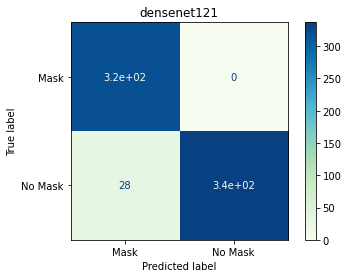

In [33]:
plot_confusion_matrix(true_values=y_train, prediction_values=pred_train)

Now we plot for the validation dataset:

In [34]:
y_valid = []
pred_valid = []
model.eval()
with torch.no_grad():
  for images, labels in validloader:
    images, labels = images.to(device), labels.to(device)
    logps = model.forward(images)
    ps = torch.exp(logps)
    for i, p in enumerate(ps.numpy()):
      y_valid.append(labels[i])
      pred_valid.append(p.argmax())
print("len(y_valid) =", len(y_valid))
print("len(pred_valid) =", len(pred_valid))

len(y_valid) = 231
len(pred_valid) = 231


TN: 111  FP: 0  FN: 8  TP: 112


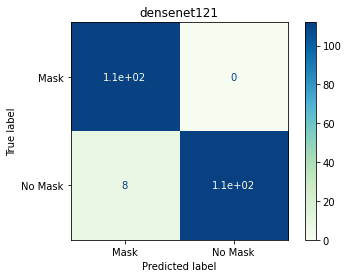

In [35]:
plot_confusion_matrix(true_values=y_valid, prediction_values=pred_valid)

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, pred_valid))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97       111
           1       1.00      0.93      0.97       120

    accuracy                           0.97       231
   macro avg       0.97      0.97      0.97       231
weighted avg       0.97      0.97      0.97       231

